In [1]:
from openai import OpenAI
import ast
import json
import pandas as pd
from IPython import display
from sklearn.model_selection import train_test_split
from pydantic import BaseModel
from tqdm import tqdm

In [ ]:
MODEL="gpt-4o-2024-08-06"
openai_api_key =  ""

In [46]:
class ClassificationResponse(BaseModel):
    Classification: int  # Expecting an integer output (1 or 0)

In [ ]:
def load_data(json_file):
    with open(json_file, 'r') as f:
        data_list = json.load(f)
    lines = [item['line'] for item in data_list]
    labels = [item['label'] for item in data_list]
    return lines, labels

lines, labels = load_data("../data/pitt_cookie_cleaned_second_try.json")
lines_train, lines_test, labels_train, labels_test = train_test_split(
        lines, labels, test_size=0.3, random_state=42
    )

In [3]:
df = pd.read_csv("../data/gpt_response_zero_shot.csv", index_col = "Unnamed: 0")

,text_patient,text_dialog,label,gpt_response_patient,gpt_response_dialog
0,this uh boy is getting uh cookies out_of this...,INV: what do you see going on in that picture ...,1,NaN,NaN
1,uh she's um w w w washing dishes . \n and this...,PAR: uh she's um w w w washing dishes . \n INV...,1,NaN,NaN
2,hm . \n xxx . \n this little boy has his hand...,INV: there's the picture . \n PAR: hm . \n PA...,0,NaN,NaN
3,is it alright to say mother and s son and daug...,INV: okay there you go . \n INV: there's the p...,1,NaN,NaN
4,well the little girl is reaching for a cookie ...,INV: take a look at that and tell me everythin...,0,NaN,NaN


In [41]:
client = OpenAI(api_key = openai_api_key)

In [52]:
def openai_ask(text):
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[
            {"role": "system", "content": "Classify the cognitive state from the dialogue."},
            {"role": "user", "content": (
                "You are an expert language model trained to identify cognitive impairments based on dialogue analysis. "
                "Your task is to classify a given dialogue as belonging to either a patient with Alzheimer’s Disease (AD), "
                "Mild Cognitive Impairment (MCI), or a healthy older adult. Please analyze the provided dialogue and return "
                "one of the following outputs:\n"
                "- Return `1` if the dialogue suggests cognitive impairment (AD or MCI).\n"
                "- Return `0` if the dialogue suggests a healthy older adult.\n\n"
                f"Dialogue for analysis:\n{text}\n\n"
                "Output should be a single number: `1` or `0`."
            )}
        ],
        response_format=ClassificationResponse,  # Using the pydantic model directly for structured output
        temperature=0.0,
    )
    return response.choices[0].message.content

In [68]:
text=df["text_dialog"][0]
text

'INV: what do you see going on in that picture ? \n PAR:  this uh boy is getting uh cookies out_of this jar . \n INV: okay . \n INV:  anything else ? \n INV:  what else do you see going on there ? \n PAR:  well ‡ why  why    they  they must have put  put something     in the uh   uh  in somethin over here .  \n INV: anything else ? \n PAR: www . \n INV: anything else you see going on over there ? \n INV:  is that it ? \n PAR: no ‡     g you gotta get the  uh the uh thing   uh out_o the uh ... \n INV:  is that it ? \n PAR:  yeah ‡ I guess so .  \n INV: okay . '

In [70]:
re = openai_ask(text)

In [ ]:
ast.literal_eval(re)["Classification"]

1

In [82]:
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    if idx < 130:
        continue
    df.at[idx, "gpt_response_patient"] = openai_ask(row["text_patient"])
    df.at[idx, "gpt_response_dialog"] = openai_ask(row["text_dialog"])

100%|██████████| 165/165 [00:26<00:00,  6.27it/s]


In [86]:
df["gpt_label_patient"] = pd.NA
df["gpt_label_dialog"] = pd.NA

In [105]:
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    df.at[idx, "gpt_label_patient"] = int(ast.literal_eval(row["gpt_response_patient"])["Classification"])
    df.at[idx, "gpt_label_dialog"] = int(ast.literal_eval(row["gpt_response_dialog"])["Classification"])
df["gpt_label_patient"] = df["gpt_label_patient"].astype(int)
df["gpt_label_dialog"] = df["gpt_label_dialog"].astype(int)

100%|██████████| 165/165 [00:00<00:00, 20810.08it/s]


Accuracy: 0.6666666666666666


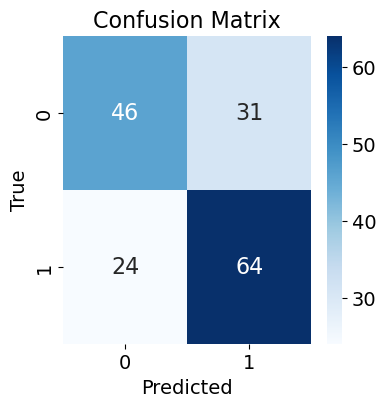

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", (df["label"] == df["gpt_label_dialog"]).mean())
cm = confusion_matrix(df["label"], df["gpt_label_dialog"])
plt.figure(figsize=(4,4))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [110]:
df.to_csv("../data/gpt_response_first_try.csv")